## REGRESIÓN DE COX

En este notebook se realiza un análisis de supervivencia utilizando el modelo de regresión de Cox, enfocado en un conjunto de datos sobre pacientes con diferentes tipos de cáncer. A través de este análisis, exploramos cómo diversas variables, tales como la edad al diagnóstico, el tipo de cáncer, el género y otras características clínicas, influyen en el riesgo relativo de muerte (hazard) a lo largo del tiempo. Se verifica si las suposiciones de proporcionalidad de riesgos se cumplen a través de pruebas estadísticas y visualizaciones y se calcula el C-Index, que nos proporciona una medida de la capacidad predictiva del modelo.

In [1]:
# Librerías
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

In [3]:
# Cargar el archivo CSV
df = pd.read_csv('Dataset.csv')

# Mostrar la información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9712 entries, 0 to 9711
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient ID                 8799 non-null   object 
 1   Age at Diagnosis           8332 non-null   float64
 2   Cancer Type                9712 non-null   object 
 3   Cancer Type Detailed       9712 non-null   object 
 4   Mutation Count             8408 non-null   float64
 5   Overall Survival (Months)  9712 non-null   float64
 6   Overall Survival Status    9712 non-null   int64  
 7   Gender                     9710 non-null   object 
 8   Ethnicity                  3814 non-null   object 
 9   Race                       4927 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 758.9+ KB


<lifelines.CoxPHFitter: fitted with 2389 total observations, 1889 right-censored observations>
             duration col = 'survival_months'
                event col = 'survival_status'
      baseline estimation = breslow
   number of observations = 2389
number of events observed = 500
   partial log-likelihood = -3259.08
         time fit was run = 2025-05-06 10:41:18 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
age_at_diagnosis                  0.02      1.02      0.00            0.01            0.03                1.01                1.03
mutation_count                   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
gender_Male                       0.24      1.27      0.13           -0.03            0.50                0.97                1.65
race_Black or African American    0.07      1.08      0.32           -0.56            0.71                0.57                2.03
race_Other                        0.88      2.41      1.08           -1.23            2.99                0.29               19.80
race_White                       -0.13      0.87      0.31           -0.74            0.47                0.48                1.60
ethnicity_Not Hispanic or Latino  0.47      1.61      0.33           -0.17            1.12                0.84                3.07
cancer_type_Colorectal Cancer     0.84      2.33      0.14            0.57            1.11                1.78                3.05
cancer_type_Lung Cancer           1.12      3.05      0.15            0.81            1.42                2.25                4.14

                                  cmp to     z      p  -log2(p)
covariate                                                      
age_at_diagnosis                    0.00  4.95 <0.005     20.34
mutation_count                      0.00 -1.04   0.30      1.74
gender_Male                         0.00  1.76   0.08      3.66
race_Black or African American      0.00  0.23   0.82      0.29
race_Other                          0.00  0.82   0.41      1.27
race_White                          0.00 -0.43   0.66      0.59
ethnicity_Not Hispanic or Latino    0.00  1.44   0.15      2.74
cancer_type_Colorectal Cancer       0.00  6.12 <0.005     30.04
cancer_type_Lung Cancer             0.00  7.20 <0.005     40.59
---
Concordance = 0.72
Partial AIC = 6536.15
log-likelihood ratio test = 209.47 on 9 df
-log2(p) of ll-ratio test = 131.11

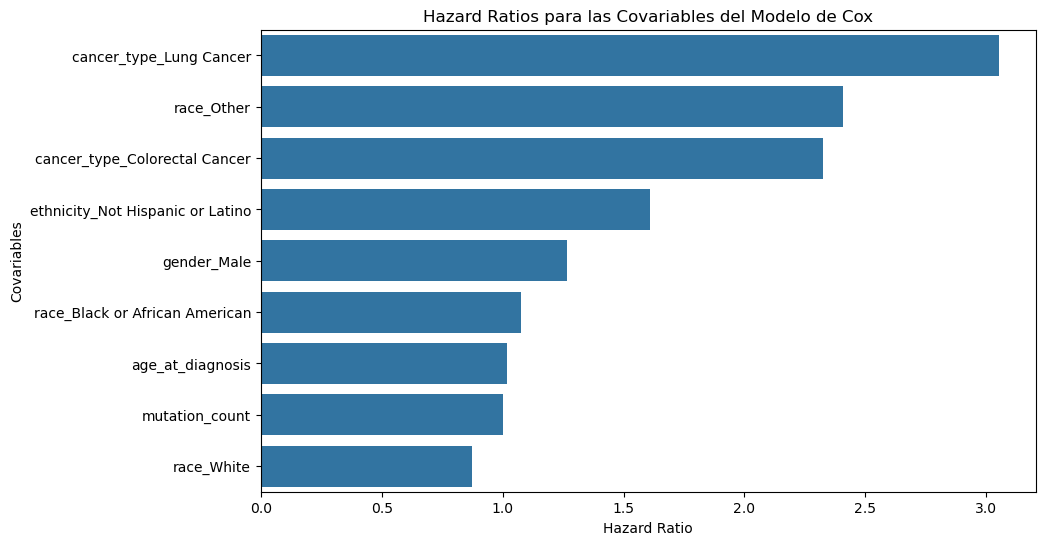

In [24]:
# Crear copia del dataframe y renombrar columnas para evitar espacios
df_cox = df.copy()
df_cox = df_cox.rename(columns={
    'Age at Diagnosis': 'age_at_diagnosis',
    'Overall Survival (Months)': 'survival_months',
    'Overall Survival Status': 'survival_status',
    'Cancer Type': 'cancer_type',
    'Gender': 'gender',
    'Race': 'race',
    'Ethnicity': 'ethnicity',
    'Mutation Count': 'mutation_count'
})

# Seleccionar solo columnas necesarias y eliminar filas con valores nulos
variables = ['age_at_diagnosis', 'mutation_count', 'gender', 'race', 'ethnicity', 'cancer_type']
df_model = df_cox[['survival_months', 'survival_status'] + variables].dropna()

# Codificar variables categóricas con one-hot encoding (sin multicolinealidad)
df_model_encoded = pd.get_dummies(df_model, columns=['gender', 'race', 'ethnicity', 'cancer_type'], drop_first=True)

# Ajustar el modelo de Cox
cph = CoxPHFitter()
cph.fit(df_model_encoded, duration_col='survival_months', event_col='survival_status')

# Mostrar el resumen del modelo
cph.print_summary()

# Paso 1: Hazard Ratios y sus intervalos de confianza
# Obtener los coeficientes del modelo y calcular el Hazard Ratio (HR)
hr = np.exp(cph.params_)

# Obtener los intervalos de confianza (tienen otro formato en lifelines)
hr_conf_int = np.exp(cph.confidence_intervals_)

# Ahora podemos acceder a los intervalos de confianza de esta forma
lower_ci = hr_conf_int.iloc[:, 0]  # Columna de lower confidence interval
upper_ci = hr_conf_int.iloc[:, 1]  # Columna de upper confidence interval

# Crear un DataFrame para visualizar los HRs y sus intervalos de confianza
hr_df = pd.DataFrame({
    'Hazard Ratio': hr,
    'Lower CI': lower_ci,
    'Upper CI': upper_ci
})
hr_df = hr_df.sort_values(by='Hazard Ratio', ascending=False)

# Visualizar los Hazard Ratios
plt.figure(figsize=(10, 6))
sns.barplot(x=hr_df['Hazard Ratio'], y=hr_df.index)
plt.title('Hazard Ratios para las Covariables del Modelo de Cox')
plt.xlabel('Hazard Ratio')
plt.ylabel('Covariables')
plt.show()


In [26]:
# Paso 2: Cálculo del C-Index
# Predecir los riesgos (log hazard ratios) en los datos
predictions = cph.predict_partial_hazard(df_model_encoded)

# Calcular el C-Index utilizando las predicciones y el evento real
cindex = concordance_index(df_model_encoded['survival_months'], predictions, df_model_encoded['survival_status'])
print(f'C-Index: {cindex}')

C-Index: 0.27595926064860254


In [28]:
# Paso 3: Verificar la suposición de riesgos proporcionales
# Usar el método check_assumptions para verificar la suposición de riesgos proporcionales
cph.check_assumptions(df_model_encoded, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2389 total observations, 1889 right-censored observations>
         test_name = proportional_hazard_test

---
                                       test_statistic      p  -log2(p)
age_at_diagnosis                 km              1.49   0.22      2.17
                                 rank            1.20   0.27      1.87
cancer_type_Colorectal Cancer    km             21.61 <0.005     18.19
                                 rank           24.70 <0.005     20.51
cancer_type_Lung Cancer          km             18.94 <0.005     16.18
                                 rank           25.80 <0.005     21.33
ethnicity_Not Hispanic or Latino km              7.24   0.01      7.13
                                 rank           10.53 <0.005      9.73
gender_Male                      km              2.92   0.09      3.51
                                 rank            3.22   0.07      3.78
mutation_count                   km              0.05   0.82      0.28
                                 rank            0.20   0.65      0.62
race_Black or African American   km              0.07   0.79      0.35
                                 rank            0.09   0.76      0.39
race_Other                       km              0.71   0.40      1.32
                                 rank            0.93   0.33      1.58
race_White                       km              0.37   0.54      0.88
                                 rank            0.05   0.82      0.29



1. Variable 'ethnicity_Not Hispanic or Latino' failed the non-proportional test: p-value is 0.0012.

   Advice: with so few unique values (only 2), you can include `strata=['ethnicity_Not Hispanic or
Latino', ...]` in the call in `.fit`. See documentation in link [E] below.

2. Variable 'cancer_type_Colorectal Cancer' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['cancer_type_Colorectal
Cancer', ...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'cancer_type_Lung Cancer' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['cancer_type_Lung Cancer',
...]` in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20haz

[]

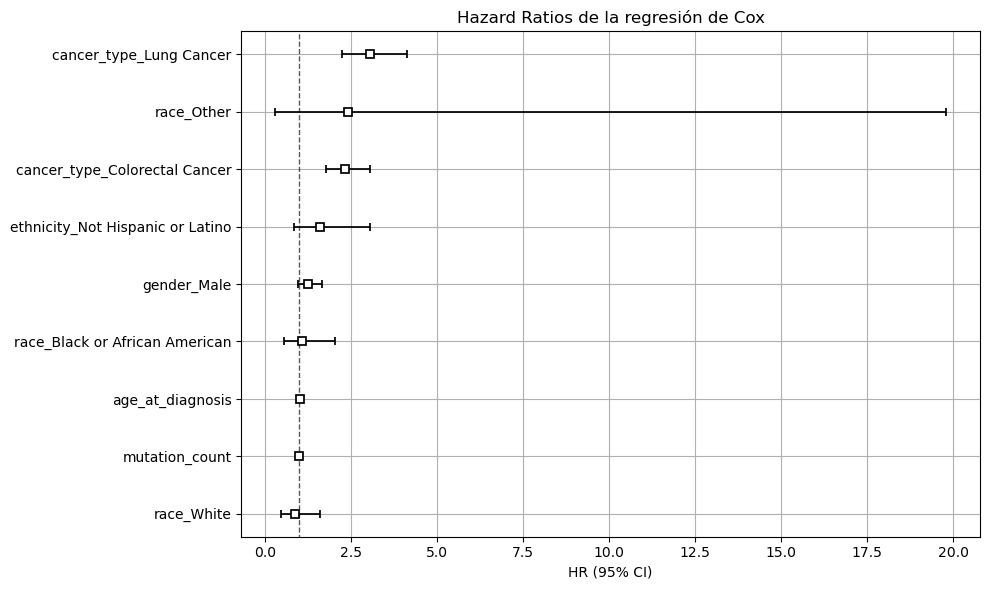

In [30]:
# Paso 4: Visualización de los coeficientes como Hazard Ratios
plt.figure(figsize=(10, 6))
cph.plot(hazard_ratios=True)
plt.title("Hazard Ratios de la regresión de Cox")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Obtener los hazard ratios (HR) y sus intervalos de confianza
hr_df = pd.DataFrame({
    'Hazard Ratio': cph.hazard_ratios_,
    'Lower CI': np.exp(cph.confidence_intervals_.iloc[:, 0]),
    'Upper CI': np.exp(cph.confidence_intervals_.iloc[:, 1])
})

# Mostrar la tabla ordenada por los hazard ratios
hr_df = hr_df.sort_values(by='Hazard Ratio', ascending=False)
print(hr_df)


                                  Hazard Ratio  Lower CI   Upper CI
covariate                                                          
cancer_type_Lung Cancer               3.051936  2.252455   4.135182
race_Other                            2.405899  0.292343  19.799877
cancer_type_Colorectal Cancer         2.325869  1.775331   3.047132
ethnicity_Not Hispanic or Latino      1.607976  0.842416   3.069252
gender_Male                           1.266573  0.972981   1.648755
race_Black or African American        1.076724  0.570156   2.033365
age_at_diagnosis                      1.018274  1.010994   1.025606
mutation_count                        0.999862  0.999601   1.000122
race_White                            0.874680  0.477155   1.603388
